In [1]:
import copy
import datetime as dt
import importlib # needed so that we can reload packages
import matplotlib.pyplot as plt
import os, os.path
import numpy as np
import pandas as pd
import pathlib
import sys
import time
from typing import Union
import warnings
from datetime import datetime
warnings.filterwarnings("ignore")

##  IMPORT SISEPUEDE EXAMPLES AND TRANSFORMERS

from sisepuede.manager.sisepuede_examples import SISEPUEDEExamples
from sisepuede.manager.sisepuede_file_structure import SISEPUEDEFileStructure
import sisepuede.core.support_classes as sc
import sisepuede.transformers as trf
import sisepuede.utilities._plotting as spu
import sisepuede.utilities._toolbox as sf

In [2]:
%load_ext autoreload
%autoreload 2

### Initial Set up

Make sure to edit the config yaml under croatia/config_files/croatia_config.yaml

You can also create a new config yaml



In [3]:
# Set up dir paths

dir_cur = pathlib.Path(os.getcwd())
dir_ssp_modeling = dir_cur.parent
dir_project = dir_ssp_modeling.parent
dir_data = dir_ssp_modeling.joinpath("input_data")
dir_scenario_mapping = dir_ssp_modeling.joinpath("scenario_mapping")
dir_config = dir_ssp_modeling.joinpath("config_files")
dir_transformations = dir_ssp_modeling.joinpath("transformations")
dir_misc = dir_ssp_modeling.joinpath("misc")
strategies_definitions_file_path = dir_transformations.joinpath("strategy_definitions.csv")
strategy_mapping_file_path = dir_misc.joinpath("strategy_mapping.yaml")

In [4]:
from ssp_transformations_handler.GeneralUtils import GeneralUtils
from ssp_transformations_handler.TransformationUtils import ExcelYAMLHandler, StrategyCSVHandler

# Initialize general utilities
g_utils = GeneralUtils()

In [5]:
# Load config file, double check your parameters are correct

yaml_file_path = os.path.join(dir_config, "mexico_config.yaml")
config_params = g_utils.get_yaml_values(yaml_file_path)

country_name = config_params['country_name']
ssp_input_file_name = config_params['ssp_input_file_name']
ssp_transformation_cw = config_params['ssp_transformation_cw']
energy_model_flag = config_params['energy_model_flag']


Country Name: mexico
SSP Input File Name: real_data_20250210.csv
SSP Transformation CW: ssp_mexico_transformation_2025_02_10.xlsx
Energy Model Flag: True


In [6]:
# Set up SSP objects

fp_data_base = dir_data.joinpath(ssp_input_file_name)

file_struct = SISEPUEDEFileStructure()

matt = file_struct.model_attributes
regions = sc.Regions(matt)
time_periods = sc.TimePeriods(matt)

### Making sure our input file has the correct format and correct columns
We use an example df with the complete fields and correct format to make sure our file is in the right shape

In [7]:
##  BUILD BASE INPUTS

df_inputs_raw = pd.read_csv(fp_data_base)

# pull example data to fill in gaps
examples = SISEPUEDEExamples()
df_inputs_example = examples.input_data_frame

In [8]:
df_inputs_example.head()

,region,time_period,avgload_trns_freight_tonne_per_vehicle_aviation,avgload_trns_freight_tonne_per_vehicle_rail_freight,avgload_trns_freight_tonne_per_vehicle_road_heavy_freight,avgload_trns_freight_tonne_per_vehicle_water_borne,avgmass_lvst_animal_buffalo_kg,avgmass_lvst_animal_cattle_dairy_kg,avgmass_lvst_animal_cattle_nondairy_kg,avgmass_lvst_animal_chickens_kg,...,ef_ippu_tonne_cf4_per_tonne_production_electronics,ef_ippu_tonne_cf4_per_tonne_production_metals,ef_ippu_tonne_c3f8_per_tonne_production_chemicals,ef_ippu_tonne_c3f8_per_tonne_production_electronics,ef_ippu_tonne_c4f10_per_mmm_gdp_product_use_ods_other,ef_ippu_tonne_c4f10_per_tonne_production_chemicals,ef_ippu_tonne_c6f14_per_mmm_gdp_product_use_ods_other,ef_ippu_tonne_c6f14_per_tonne_production_chemicals,ef_ippu_tonne_cc4f8_per_tonne_production_chemicals,ef_ippu_tonne_cc4f8_per_tonne_production_electronics
0,costa_rica,0,70.0,2923.0,31.751466,6468.0,322.900664,520.741388,310.599686,1.12759,...,0.000002,4.204879e-07,0.0,1.515048e-07,0.0,0.0,0.0,0.0,0.0,5.669821e-08
1,costa_rica,1,70.0,2923.0,31.751466,6468.0,322.900664,520.741388,310.599686,1.12759,...,0.000002,2.134675e-07,0.0,1.313925e-07,0.0,0.0,0.0,0.0,0.0,5.185820e-08
2,costa_rica,2,70.0,2923.0,31.751466,6468.0,322.900664,520.741388,310.599686,1.12759,...,0.000002,1.821067e-07,0.0,1.060066e-07,0.0,0.0,0.0,0.0,0.0,5.269348e-08
3,costa_rica,3,70.0,2923.0,31.751466,6468.0,322.900664,520.741388,310.599686,1.12759,...,0.000002,2.094712e-07,0.0,1.093024e-07,0.0,0.0,0.0,0.0,0.0,5.500450e-08
4,costa_rica,4,70.0,2923.0,31.751466,6468.0,322.900664,520.741388,310.599686,1.12759,...,0.000002,3.446161e-07,0.0,1.046451e-07,0.0,0.0,0.0,0.0,0.0,5.266081e-08


In [9]:
# Checks if there are any differences in columns between the example df and our df
g_utils.compare_dfs(df_inputs_example, df_inputs_raw)


Columns in df_example but not in df_input: {'energydensity_gravimetric_enfu_gj_per_tonne_fuel_water', 'strategy_id', 'ef_trns_mobile_combustion_water_borne_kg_n2o_per_tj_ammonia', 'nemomod_entc_grid_power_constraint_mmm_usd', 'nemomod_entc_input_activity_ratio_fuel_production_fp_ammonia_production_electricity', 'frac_trns_fuelmix_water_borne_ammonia', 'nemomod_entc_input_activity_ratio_fuel_production_fp_ammonia_production_hydrogen', 'nemomod_entc_fixed_cost_fp_hydrogen_reformation_ccs_mm_usd_per_gw', 'nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_electrolysis_water', 'nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_oil', 'nemomod_entc_emissions_activity_ratio_scalar_fp_hydrogen_reformation_ccs_co2', 'ef_enfu_stationary_combustion_tonne_ch4_per_tj_fuel_ammonia', 'nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_electricity', 'nemomod_entc_capital_cost_fp_hydrogen_reformation_ccs_mm_usd_per_gw', 'nemomod_entc_cap

In [10]:
# Fixes differences and makes sure that our df is in the correct format.
# Note: Edit this if you need more changes in your df

df_inputs_raw = df_inputs_raw.rename(columns={'period':'time_period'})
df_inputs_raw_complete = g_utils.add_missing_cols(df_inputs_example, df_inputs_raw.copy())
df_inputs_raw_complete = df_inputs_raw_complete.drop(columns='iso_code3', errors='ignore')
df_inputs_raw_complete.head()

,Year,pij_lndu_forests_primary_to_croplands,pij_lndu_forests_mangroves_to_wetlands,yf_agrc_nuts_tonne_ha,ef_lndu_conv_forests_secondary_to_other_gg_co2_ha,ef_lndu_conv_forests_secondary_to_wetlands_gg_co2_ha,ef_lndu_conv_other_to_forests_primary_gg_co2_ha,pij_lndu_forests_mangroves_to_forests_secondary,ef_lndu_conv_wetlands_to_settlements_gg_co2_ha,pij_lndu_grasslands_to_forests_secondary,...,nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_electrolysis_water,nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_electricity,energydensity_gravimetric_enfu_gj_per_tonne_fuel_ammonia,energydensity_gravimetric_enfu_gj_per_tonne_fuel_water,frac_trns_fuelmix_water_borne_ammonia,nemomod_entc_output_activity_ratio_fuel_production_fp_ammonia_production_ammonia,nemomod_entc_output_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_hydrogen,nemomod_entc_frac_min_share_production_fp_hydrogen_reformation_ccs,nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_natural_gas,nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_oil
0,2015,0.000000,0.0,1.497014,0.128343,0.129618,0.0,0.0,0.0,0.0,...,0.000004,0,18.6,0.00005,0.0,1,1,0.0,1.315,0.0
1,2016,0.000000,0.0,1.438057,0.128343,0.129618,0.0,0.0,0.0,0.0,...,0.000004,0,18.6,0.00005,0.0,1,1,0.0,1.315,0.0
2,2017,0.000000,0.0,1.435714,0.128343,0.129618,0.0,0.0,0.0,0.0,...,0.000004,0,18.6,0.00005,0.0,1,1,0.0,1.315,0.0
3,2018,0.000016,0.0,1.464529,0.128343,0.129618,0.0,0.0,0.0,0.0,...,0.000004,0,18.6,0.00005,0.0,1,1,0.0,1.315,0.0
4,2019,0.000031,0.0,1.452086,0.128343,0.129618,0.0,0.0,0.0,0.0,...,0.000004,0,18.6,0.00005,0.0,1,1,0.0,1.315,0.0


In [11]:
# Double checking that our df is in the correct shape (Empty sets should be printed to make sure everything is Ok!)
g_utils.compare_dfs(df_inputs_example, df_inputs_raw_complete)

Columns in df_example but not in df_input: set()
Columns in df_input but not in df_example: {'nemomod_entc_variable_cost_pp_gas_mm_usd_per_gw', 'demscalar_ippu_recycled_textiles', 'nemomod_entc_variable_cost_pp_waste_incineration_mm_usd_per_gw', 'nemomod_entc_variable_cost_pp_coal_mm_usd_per_mwh', 'nemomod_entc_variable_cost_pp_coal_mm_usd_per_gw', 'nemomod_entc_variable_cost_pp_waste_incineration_mm_usd_per_mwh', 'cost_enfu_fuel_hydrogen_usd_per_tonne', 'nemomod_entc_variable_cost_pp_biomass_mm_usd_per_gw', 'nemomod_entc_variable_cost_pp_solar_mm_usd_per_mwh', 'demscalar_ippu_recycled_wood', 'nemomod_entc_variable_cost_pp_nuclear_mm_usd_per_mwh', 'demscalar_ippu_recycled_rubber_and_leather', 'nemomod_entc_variable_cost_pp_hydropower_mm_usd_per_mwh', 'nemomod_entc_variable_cost_pp_geothermal_mm_usd_per_gw', 'nemomod_entc_variable_cost_pp_wind_mm_usd_per_gw', 'va_commercial_mmm_usd', 'frac_trns_fuelmix_rail_passenger_diesel.1', 'nemomod_entc_variable_cost_pp_oil_mm_usd_per_gw', 'nemomod

In [12]:
# Checking if there are any columns with null values in it
columns_with_na = df_inputs_raw_complete.columns[df_inputs_raw_complete.isna().any()].tolist()

print(columns_with_na)

[]


In [13]:
# Checking region to avoid copy errors
df_inputs_raw_complete['region'].head()

0    costa_rica
1    costa_rica
2    costa_rica
3    costa_rica
4    costa_rica
Name: region, dtype: object

In [14]:
# Set region to country name
df_inputs_raw_complete['region'] = country_name
df_inputs_raw_complete['region'].head()

0    mexico
1    mexico
2    mexico
3    mexico
4    mexico
Name: region, dtype: object

In [15]:
# Normalize ENERGY frac_vars
# df_inputs_raw_complete = g_utils.normalize_energy_frac_vars(df_inputs_raw_complete, os.path.join(dir_misc, "energy_frac_vars.xlsx"))

In [16]:
# df_inputs_raw_complete.to_csv(dir_data.joinpath('croatia_input_complete.csv'), index=False)

#  Let's try building transformations using this


In [17]:
transformers = trf.transformers.Transformers(
    {},
    df_input = df_inputs_raw_complete,
)

##  Instantiate some transformations. Make sure to run this cell to create the transformations folder for the first time or if you wish to overwrite

In [18]:
# set an ouput path and instantiate
if not dir_transformations.exists():
    trf.instantiate_default_strategy_directory(
        transformers,
        dir_transformations,
    )
else:
    print(f"Directory {dir_transformations} already exists. Skipping instantiation.")


Directory /home/tony-ubuntu/decision_sciences/ssp_mexico/ssp_modeling/transformations already exists. Skipping instantiation.


##  --HERE, CUSTOMIZE YOUR TRANSFORMATIONS AND STRATEGIES--

### Customizing transformations and strategies files using TransformationUtils.py classes

In [19]:
# Generate new transformation files based on the excel mapping file. 
# Make sure to have the most updated format for the excel file, check the one used in this notebook for reference.

cw_file_path = os.path.join(dir_scenario_mapping, ssp_transformation_cw)
print(cw_file_path)
excel_yaml_handler = ExcelYAMLHandler(excel_file=cw_file_path, yaml_directory=dir_transformations)

/home/tony-ubuntu/decision_sciences/ssp_mexico/ssp_modeling/scenario_mapping/ssp_mexico_transformation_2025_02_10.xlsx


In [20]:
# This creates transformation yaml files for each strategy in the excel file

# Use if its the first time you are running this
# excel_yaml_handler.process_yaml_files()

# Use if you have already created the yaml files and just want to update them so the transformations with multiple params are not overwritten
# NOTE: This is a temporary solution, we need to find a better way to handle this
excel_yaml_handler.process_yaml_files(overwrite_mult_param_transformations=False)

YAML file transformation_agrc_inc_conservation_agriculture.yaml for strategy strategy_SV wasn't updated. Please check it manually.


In [21]:
# Load the transformations per strategy dictionary so we can pass it to the strategy handler
# You can also check here if the transformations in each strategy are correct
transformation_per_strategy_dict = excel_yaml_handler.get_transformations_per_strategy_dict()
transformation_per_strategy_dict

{'strategy_M8_EC': ['TX:WASO:INC_RECYCLING_STRATEGY_M8_EC'],
 'strategy_M7_EE': ['TX:INEN:INC_EFFICIENCY_ENERGY_STRATEGY_M7_EE',
  'TX:SCOE:INC_EFFICIENCY_APPLIANCE_STRATEGY_M7_EE'],
 'strategy_M6_TF': ['TX:TRNS:SHIFT_FUEL_RAIL_STRATEGY_M6_TF',
  'TX:TRNS:SHIFT_MODE_FREIGHT_STRATEGY_M6_TF',
  'TX:TRNS:SHIFT_MODE_PASSENGER_STRATEGY_M6_TF'],
 'strategy_M5_TR': ['TX:TRDE:DEC_DEMAND_STRATEGY_M5_TR',
  'TX:TRNS:SHIFT_MODE_PASSENGER_STRATEGY_M5_TR'],
 'strategy_M4_EV': ['TX:TRNS:SHIFT_FUEL_LIGHT_DUTY_STRATEGY_M4_EV',
  'TX:TRNS:SHIFT_FUEL_MEDIUM_DUTY_STRATEGY_M4_EV'],
 'strategy_M3_CA': ['TX:LNDU:DEC_DEFORESTATION_STRATEGY_M3_CA'],
 'strategy_M2_ANP': ['TX:LNDU:DEC_DEFORESTATION_STRATEGY_M2_ANP',
  'TX:LNDU:INC_REFORESTATION_STRATEGY_M2_ANP'],
 'strategy_SV': ['TX:AGRC:INC_CONSERVATION_AGRICULTURE_STRATEGY_SV',
  'TX:LNDU:INC_REFORESTATION_STRATEGY_SV',
  'TX:SOIL:DEC_N_APPLIED_STRATEGY_SV']}

### Creating new strategies
- You can create new strategies from scratch.
- You can also update existing ones.

In [22]:
# Creating new strategies by updating the strategy_definitions file.
# You can edit this to add yours, as many as you want.
csv_handler = StrategyCSVHandler(strategies_definitions_file_path, dir_transformations, strategy_mapping_file_path, transformation_per_strategy_dict)

# Uncomment for completly new strategies version
csv_handler.add_strategy(strategy_group='PFLO', description='Mexico M8 Economia Circular', yaml_file_suffix='M8_EC')
csv_handler.add_strategy(strategy_group='PFLO', description='Mexico M7 Eficiencia Energetica', yaml_file_suffix='M7_EE')
csv_handler.add_strategy(strategy_group='PFLO', description='Mexico M6 Fomento al Transporte Ferroviario', yaml_file_suffix='M6_TF')
csv_handler.add_strategy(strategy_group='PFLO', description='Mexico M5 Estrategia de Trabajo Remoto', yaml_file_suffix='M5_TR')
csv_handler.add_strategy(strategy_group='PFLO', description='Mexico M4 Pacto de Glasgow por la Electromovilidad', yaml_file_suffix='M4_EV')
csv_handler.add_strategy(strategy_group='PFLO', description='Mexico M3 Estrategia de Carbono Azul', yaml_file_suffix='M3_CA')
csv_handler.add_strategy(strategy_group='PFLO', description='Mexico M2 Nuevas Areas Naturales Protegidas', yaml_file_suffix='M2_ANP')
csv_handler.add_strategy(strategy_group='PFLO', description='Mexico Programa Sembrando Vida', yaml_file_suffix='SV')



# Uncomment to update the strategies that are currently in the strategy_definitions file
# csv_handler.add_strategy(strategy_group='PFLO', description='Croatia WEM scenario', yaml_file_suffix='WEM', custom_id=6003, update_flag=True)
# csv_handler.add_strategy(strategy_group='PFLO', description='Croatia WAM scenario', yaml_file_suffix='WAM', custom_id=6004, update_flag=True)
# csv_handler.add_strategy(strategy_group='PFLO', description='Croatia NZ scenario', yaml_file_suffix='NZ', custom_id=6005, update_flag=True)


Error: strategy_code PFLO:M8_EC already exists. Please use a different code or eliminate the existing one.
Error: strategy_code PFLO:M7_EE already exists. Please use a different code or eliminate the existing one.
Error: strategy_code PFLO:M6_TF already exists. Please use a different code or eliminate the existing one.
Error: strategy_code PFLO:M5_TR already exists. Please use a different code or eliminate the existing one.
Error: strategy_code PFLO:M4_EV already exists. Please use a different code or eliminate the existing one.
Error: strategy_code PFLO:M3_CA already exists. Please use a different code or eliminate the existing one.
Error: strategy_code PFLO:M2_ANP already exists. Please use a different code or eliminate the existing one.
Error: strategy_code PFLO:SV already exists. Please use a different code or eliminate the existing one.


In [23]:
# Set up the strategy codes you wish to run in ssp
strategies_to_run = [0, 6003, 6004, 6005, 6006, 6007, 6008, 6009, 6010]

### We finished adding new transformation files and strategies so lets load them back

In [24]:
# then, you can load this back in after modifying (play around with it)
transformations = trf.Transformations(
    dir_transformations,
    transformers = transformers,
)
tab = transformations.attribute_transformation.table

In [25]:
#  build the strategies -- will export to path
t0 = time.time()
strategies = trf.Strategies(
    transformations,
    export_path = "transformations",
    prebuild = True,
)

t_elapse = sf.get_time_elapsed(t0)
print(f"Strategies defined at {strategies.transformations.dir_init} initialized in {t_elapse} seconds")

Strategies defined at /home/tony-ubuntu/decision_sciences/ssp_mexico/ssp_modeling/transformations initialized in 3.81 seconds


In [26]:
strategies.attribute_table

,strategy_id,strategy_code,strategy,description,transformation_specification,baseline_strategy_id
0,0,BASE,Strategy TX:BASE,NaN,TX:BASE,1
1,1000,AGRC:DEC_CH4_RICE,Singleton - Default Value - AGRC: Improve rice...,NaN,TX:AGRC:DEC_CH4_RICE,0
2,1001,AGRC:DEC_EXPORTS,Singleton - Default Value - AGRC: Decrease Exp...,NaN,TX:AGRC:DEC_EXPORTS,0
3,1002,AGRC:DEC_LOSSES_SUPPLY_CHAIN,Singleton - Default Value - AGRC: Reduce suppl...,NaN,TX:AGRC:DEC_LOSSES_SUPPLY_CHAIN,0
4,1003,AGRC:INC_CONSERVATION_AGRICULTURE,Singleton - Default Value - AGRC: Expand conse...,NaN,TX:AGRC:INC_CONSERVATION_AGRICULTURE,0
...,...,...,...,...,...,...
72,6006,PFLO:M5_TR,M5_TR,Mexico M5 Estrategia de Trabajo Remoto,TX:TRDE:DEC_DEMAND_STRATEGY_M5_TR|TX:TRNS:SHIF...,0
73,6007,PFLO:M4_EV,M4_EV,Mexico M4 Pacto de Glasgow por la Electromovil...,TX:TRNS:SHIFT_FUEL_LIGHT_DUTY_STRATEGY_M4_EV|T...,0
74,6008,PFLO:M3_CA,M3_CA,Mexico M3 Estrategia de Carbono Azul,TX:LNDU:DEC_DEFORESTATION_STRATEGY_M3_CA,0
75,6009,PFLO:M2_ANP,M2_ANP,Mexico M2 Nuevas Areas Naturales Protegidas,TX:LNDU:DEC_DEFORESTATION_STRATEGY_M2_ANP|TX:L...,0


##  Build our templates
- let's use the default variable groupings for LHS

In [27]:
# Building excel templates, make sure to include the strategies ids in the strategies attribute as well as the baseline (0)
df_vargroups = examples("variable_trajectory_group_specification")

strategies.build_strategies_to_templates(
    df_trajgroup = df_vargroups,
    include_simplex_group_as_trajgroup = True,
    strategies = strategies_to_run,
)

0

# Finally, load SISEPUEDE so that we can run it

In [28]:
country_name

'mexico'

In [29]:
import sisepuede as si
# timestamp_str = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
ssp = si.SISEPUEDE(
    "calibrated",
    db_type = "csv",
    # id_str = f"sisepuede_run_2024-11-04T09:23:26.721580",
    initialize_as_dummy = not(energy_model_flag), # no connection to Julia is initialized if set to True
    regions = [country_name],
    strategies = strategies,
    try_exogenous_xl_types_in_variable_specification = True,
)

2025-02-10 18:00:51,156 - INFO - Successfully initialized SISEPUEDEFileStructure.
2025-02-10 18:00:51,159 - WARNING - Missing key dict_dimensional_keys: key time_series not found. Tables that rely on the time_series will not have index checking.
2025-02-10 18:00:51,160 - INFO - 	Setting export engine to 'csv'.
2025-02-10 18:00:51,161 - WARNING - No index fields defined. Index field values will not be checked when writing to tables.
2025-02-10 18:00:51,161 - INFO - Successfully instantiated table ANALYSIS_METADATA
2025-02-10 18:00:51,162 - WARNING - No index fields found in ATTRIBUTE_DESIGN. Initializing index fields.
2025-02-10 18:00:51,162 - INFO - Successfully instantiated table ATTRIBUTE_DESIGN
2025-02-10 18:00:51,163 - WARNING - No index fields found in ATTRIBUTE_LHC_SAMPLES_EXOGENOUS_UNCERTAINTIES. Initializing index fields.
2025-02-10 18:00:51,163 - INFO - Successfully instantiated table ATTRIBUTE_LHC_SAMPLES_EXOGENOUS_UNCERTAINTIES
2025-02-10 18:00:51,164 - WARNING - No index fi

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


Precompiling NemoMod...
Info Given NemoMod was explicitly requested, output will be shown live 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
   3938.8 ms  ? NemoMod
[ Info: Precompiling NemoMod [a3c327a0-d2f0-11e8-37fd-d12fd35c3c72] 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
┌ Info: Skipping precompilation due to precompilable error. Importing NemoMod [a3c327a0-d2f0-11e8-37fd-d12fd35c3c72].
└   exception = Error when precompiling module, potentially caused by a __precompile__(false) declaration in the module.
2025-02-10 18:02:13,021 - INFO - Successfully initialized JuMP optimizer from solver module HiGHS.
2025-02-10 18:02:13,053 - INFO - Successfully initialized SISEPUEDEModels.
2025-02-10 18:02:13,064 - INFO - Table ANALYSIS_METADATA successfully written to /home/tony-ubuntu/anaconda3/envs/mexico_env/lib/python3

In [30]:
not(energy_model_flag)

False

In [31]:
# This runs the model, make sure you edit key_stretegy with the strategy ids you want to execute include baseline (0)
dict_scens = {
    ssp.key_design: [0],
    ssp.key_future: [0],
    ssp.key_strategy: strategies_to_run,
}

ssp.project_scenarios(
    dict_scens,
    save_inputs = True,
    include_electricity_in_energy = energy_model_flag
)

2025-02-10 18:02:13,411 - INFO - 
***	STARTING REGION mexico	***



2025-02-10 18:02:17,696 - INFO - Trying run primary_id = 0 in region mexico
2025-02-10 18:02:17,697 - INFO - Running AFOLU model
2025-02-10 18:02:17,921 - INFO - AFOLU model run successfully completed
2025-02-10 18:02:17,922 - INFO - Running CircularEconomy model
2025-02-10 18:02:17,981 - INFO - CircularEconomy model run successfully completed
2025-02-10 18:02:17,982 - INFO - Running IPPU model
2025-02-10 18:02:18,084 - INFO - IPPU model run successfully completed
2025-02-10 18:02:18,085 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-02-10 18:02:18,108 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-02-10 18:02:18,198 - ERROR - Error running EnergyConsumption without Fugitive Emissions: Invalid summations found: some categories exceed the sum threshold.Energy fractions by category do not sum to 1. See definition of dict_arrs_trns_frac_fuel.
2025-02-10 18:02:18,19

{'mexico': [0, 69069, 70070, 71071, 72072, 73073, 74074, 75075, 76076]}

In [32]:
# df_run = ssp.generate_scenario_database_from_primary_key(0)
# df_run = df_run.get("iran")
# df_run.to_csv("/Users/usuario/Desktop/iran_baselines_temp.csv", encoding = "UTF-8", index = None, )

In [33]:
# Read input and output files
df_out = ssp.read_output(None)
df_in = ssp.read_input(None)

## Some testing for Croatia (you can delete this section for a new country)

In [34]:
df_out.head()

,primary_id,region,time_period,area_agrc_crops_bevs_and_spices,area_agrc_crops_cereals,area_agrc_crops_fibers,area_agrc_crops_fruits,area_agrc_crops_herbs_and_other_perennial_crops,area_agrc_crops_nuts,area_agrc_crops_other_annual,...,yield_agrc_fruits_tonne,yield_agrc_herbs_and_other_perennial_crops_tonne,yield_agrc_nuts_tonne,yield_agrc_other_annual_tonne,yield_agrc_other_woody_perennial_tonne,yield_agrc_pulses_tonne,yield_agrc_rice_tonne,yield_agrc_sugar_cane_tonne,yield_agrc_tubers_tonne,yield_agrc_vegetables_and_vines_tonne
0,0,mexico,0,1.498417e+06,3.333018e+06,691577.302480,1.802583e+06,2.326069e+06,1.269493e+06,1.679316e+06,...,2.540248e+07,1.309418e+07,1.900449e+06,1.607561e+06,6.286518e+06,2.804834e+06,3.096085e+06,7.575189e+07,1.838938e+07,8.108195e+06
1,0,mexico,1,1.461591e+06,3.247910e+06,673743.850372,1.753218e+06,2.346959e+06,1.294457e+06,1.515300e+06,...,2.606020e+07,1.293186e+07,1.861503e+06,1.792882e+06,6.304198e+06,2.852284e+06,3.179772e+06,7.525014e+07,1.818125e+07,8.192277e+06
2,0,mexico,2,1.356992e+06,3.359503e+06,647923.645937,1.676929e+06,1.920247e+06,1.287366e+06,1.436709e+06,...,2.561986e+07,1.573308e+07,1.848289e+06,1.636063e+06,6.338401e+06,2.799054e+06,3.147456e+06,7.488968e+07,1.840122e+07,8.207416e+06
3,0,mexico,3,1.318551e+06,3.129763e+06,649901.851891,1.706077e+06,1.834059e+06,1.308020e+06,1.347544e+06,...,2.557463e+07,1.397080e+07,1.915632e+06,1.759777e+06,6.602964e+06,2.879428e+06,3.136462e+06,7.539066e+07,1.930299e+07,8.455598e+06
4,0,mexico,4,1.298439e+06,3.025514e+06,679968.764211,1.709793e+06,1.843056e+06,1.328374e+06,1.348449e+06,...,2.617928e+07,1.336588e+07,1.933932e+06,1.660667e+06,6.725325e+06,2.875121e+06,3.196320e+06,7.791245e+07,1.889613e+07,8.365308e+06


In [35]:
# Checking we've got an output df
df_out[[col for col in df_out.columns if 'subsector' in col]].head()

,emission_co2e_subsector_total_agrc,emission_co2e_subsector_total_frst,emission_co2e_subsector_total_ippu,emission_co2e_subsector_total_lndu,emission_co2e_subsector_total_lsmm,emission_co2e_subsector_total_lvst,emission_co2e_subsector_total_soil,emission_co2e_subsector_total_trww,emission_co2e_subsector_total_waso
0,24.931922,-48.445445,159.889226,26.328912,13.151220,141.753323,15.735928,22.352987,68.051308
1,24.478068,-48.396717,162.400624,26.323574,13.152876,141.753342,16.073343,22.585136,69.851663
2,23.333281,-48.343127,165.003617,26.761500,13.157613,141.789788,16.466537,22.811297,71.523496
3,23.006970,-48.293877,167.407589,26.860184,13.142243,141.606972,16.697216,23.031581,73.082092
4,22.854344,-48.235331,167.341831,34.080061,13.126078,141.417656,17.055548,23.246217,74.540731


In [36]:
df_out[[col for col in df_out.columns if 'subsector' in col]].tail()

,emission_co2e_subsector_total_agrc,emission_co2e_subsector_total_frst,emission_co2e_subsector_total_ippu,emission_co2e_subsector_total_lndu,emission_co2e_subsector_total_lsmm,emission_co2e_subsector_total_lvst,emission_co2e_subsector_total_soil,emission_co2e_subsector_total_trww,emission_co2e_subsector_total_waso
319,24.158697,-49.562994,196.242252,27.773365,12.270062,132.360685,15.101553,31.793775,128.582939
320,23.936474,-49.928794,197.743266,27.934840,12.240682,131.976457,15.098016,32.229713,131.095360
321,23.681729,-50.317460,199.239411,28.141350,12.208700,131.559789,15.311947,32.663713,133.615342
322,23.305269,-50.775055,200.730896,28.438253,12.172179,131.089496,15.886061,33.095852,136.142323
323,22.788210,-51.308453,202.217917,28.653004,12.129105,130.543547,16.440878,33.526202,138.675760


In [37]:
cement_df = df_out[['primary_id', 'time_period'] + [col for col in df_out.columns if 'prod_ippu_cement_tonne' in col]]
cement_df['year'] = cement_df['time_period'] + 2015
cement_df[cement_df.primary_id == 0]

,primary_id,time_period,prod_ippu_cement_tonne,year
0,0,0,4.635000e+07,2015
1,0,1,4.636728e+07,2016
2,0,2,4.638445e+07,2017
3,0,3,4.640152e+07,2018
4,0,4,4.641848e+07,2019
5,0,5,4.643534e+07,2020
6,0,6,4.646966e+07,2021
7,0,7,4.650357e+07,2022
8,0,8,4.653707e+07,2023
9,0,9,4.657017e+07,2024


In [38]:
mining_df = df_out[['primary_id', 'time_period'] + [col for col in df_out.columns if 'prod_ippu_mining_tonne' in col]]
mining_df['year'] = mining_df['time_period'] + 2015
mining_df[mining_df.primary_id == 0]

,primary_id,time_period,prod_ippu_mining_tonne,year
0,0,0,2.062362e+08,2015
1,0,1,2.069112e+08,2016
2,0,2,2.075840e+08,2017
3,0,3,2.082547e+08,2018
4,0,4,2.089232e+08,2019
5,0,5,2.095895e+08,2020
6,0,6,2.109496e+08,2021
7,0,7,2.123009e+08,2022
8,0,8,2.136436e+08,2023
9,0,9,2.149780e+08,2024


In [39]:
df_inputs_raw_complete['lndu_reallocation_factor'].mean()

0.5

In [40]:
df_in['lndu_reallocation_factor'].mean()

0.3333333333333333

In [41]:
df_inputs_raw_complete['elasticity_ippu_cement_production_to_gdp'].head()

0    0.056947
1    0.056947
2    0.056947
3    0.056947
4    0.056947
Name: elasticity_ippu_cement_production_to_gdp, dtype: float64

In [42]:
df_in[['primary_id', 'time_period', 'elasticity_ippu_cement_production_to_gdp']].head()

,primary_id,time_period,elasticity_ippu_cement_production_to_gdp
0,0,0,0.056947
1,0,1,0.056947
2,0,2,0.056947
3,0,3,0.056947
4,0,4,0.056947


In [43]:
[col for col in df_out.columns if 'lvst' in col]

['demand_lvst_buffalo',
 'demand_lvst_cattle_dairy',
 'demand_lvst_cattle_nondairy',
 'demand_lvst_chickens',
 'demand_lvst_goats',
 'demand_lvst_horses',
 'demand_lvst_mules',
 'demand_lvst_pigs',
 'demand_lvst_sheep',
 'emission_co2e_ch4_lvst_entferm_buffalo',
 'emission_co2e_ch4_lvst_entferm_cattle_dairy',
 'emission_co2e_ch4_lvst_entferm_cattle_nondairy',
 'emission_co2e_ch4_lvst_entferm_chickens',
 'emission_co2e_ch4_lvst_entferm_goats',
 'emission_co2e_ch4_lvst_entferm_horses',
 'emission_co2e_ch4_lvst_entferm_mules',
 'emission_co2e_ch4_lvst_entferm_pigs',
 'emission_co2e_ch4_lvst_entferm_sheep',
 'emission_co2e_subsector_total_lvst',
 'exportsadj_lvst_buffalo',
 'exportsadj_lvst_cattle_dairy',
 'exportsadj_lvst_cattle_nondairy',
 'exportsadj_lvst_chickens',
 'exportsadj_lvst_goats',
 'exportsadj_lvst_horses',
 'exportsadj_lvst_mules',
 'exportsadj_lvst_pigs',
 'exportsadj_lvst_sheep',
 'importssadj_lvst_buffalo',
 'importssadj_lvst_cattle_dairy',
 'importssadj_lvst_cattle_nonda

In [44]:
df_out[['primary_id', 'time_period'] + [col for col in df_out.columns if 'demand_lvst' in col]].head(36)

,primary_id,time_period,demand_lvst_buffalo,demand_lvst_cattle_dairy,demand_lvst_cattle_nondairy,demand_lvst_chickens,demand_lvst_goats,demand_lvst_horses,demand_lvst_mules,demand_lvst_pigs,demand_lvst_sheep
0,0,0,0.0,3.811307e+07,4.066519e+07,588369.367810,1.025900e+07,7.748633e+06,4.450201e+06,2.094055e+07,1.085819e+07
1,0,1,0.0,3.814255e+07,4.065859e+07,587432.631175,1.025564e+07,7.746097e+06,4.448745e+06,2.093715e+07,1.085463e+07
2,0,2,0.0,3.815668e+07,4.063847e+07,586357.850084,1.024898e+07,7.741067e+06,4.445855e+06,2.092679e+07,1.084758e+07
3,0,3,0.0,3.815581e+07,4.060505e+07,585146.546921,1.023907e+07,7.733582e+06,4.441558e+06,2.090958e+07,1.083709e+07
4,0,4,0.0,3.814056e+07,4.055881e+07,583802.505259,1.022602e+07,7.723728e+06,4.435898e+06,2.088576e+07,1.082329e+07
5,0,5,0.0,3.811135e+07,4.050005e+07,582326.986292,1.020992e+07,7.711564e+06,4.428912e+06,2.085551e+07,1.080624e+07
6,0,6,0.0,3.743284e+07,3.994300e+07,578075.660322,1.007724e+07,7.611350e+06,4.371357e+06,2.056866e+07,1.066581e+07
7,0,7,0.0,3.739181e+07,3.992399e+07,578377.279028,1.007363e+07,7.608625e+06,4.369792e+06,2.055887e+07,1.066199e+07
8,0,8,0.0,3.734256e+07,3.989535e+07,578523.674210,1.006756e+07,7.604044e+06,4.367162e+06,2.054412e+07,1.065557e+07
9,0,9,0.0,3.728515e+07,3.985711e+07,578518.107059,1.005905e+07,7.597613e+06,4.363468e+06,2.052443e+07,1.064656e+07


In [45]:
df_out[['primary_id', 'time_period'] + [col for col in df_out.columns if 'pop_lvst' in col]].head(37)

,primary_id,time_period,pop_lvst_buffalo,pop_lvst_cattle_dairy,pop_lvst_cattle_nondairy,pop_lvst_chickens,pop_lvst_goats,pop_lvst_horses,pop_lvst_mules,pop_lvst_pigs,pop_lvst_sheep
0,0,0,0,33502622,33502622,534692,8724945,6364159,3282880,16364458,8710780
1,0,1,0,33509439,33493771,534000,8721920,6361953,3281742,16361804,8707760
2,0,2,0,33524439,33494274,533206,8721377,6361558,3281538,16353706,8707218
3,0,3,0,33486969,33443426,532311,8707506,6351440,3276319,16340260,8693368
4,0,4,0,33447550,33391668,531318,8693440,6341180,3271027,16321651,8679324
5,0,5,0,33404622,33337379,530228,8678755,6330469,3265502,16298010,8664663
6,0,6,0,33077440,33078953,527087,8614783,6283810,3241433,16073861,8600788
7,0,7,0,32984390,32996107,527310,8593712,6268440,3233505,16066211,8579750
8,0,8,0,32899810,32921369,527418,8574741,6254603,3226368,16054686,8560810
9,0,9,0,32820486,32851530,527414,8557034,6241687,3219705,16039300,8543132


In [46]:
df_in[ 'elasticity_protein_in_diet_to_gdppc']

0      0.1950
1      0.1925
2      0.1900
3      0.1875
4      0.1850
        ...  
319    0.1175
320    0.1150
321    0.1125
322    0.1100
323    0.1075
Name: elasticity_protein_in_diet_to_gdppc, Length: 324, dtype: float64

In [47]:
df_in['frac_gnrl_eating_red_meat']

0      1.00
1      0.99
2      0.98
3      0.97
4      0.96
       ... 
319    0.70
320    0.70
321    0.70
322    0.70
323    0.70
Name: frac_gnrl_eating_red_meat, Length: 324, dtype: float64

In [48]:
df_in[df_in.time_period == 5][['time_period'] + [col for col in df_in.columns if 'pop_lvst' in col]].head(6)

,time_period,pop_lvst_initial_buffalo,pop_lvst_initial_cattle_dairy,pop_lvst_initial_cattle_nondairy,pop_lvst_initial_chickens,pop_lvst_initial_goats,pop_lvst_initial_horses,pop_lvst_initial_mules,pop_lvst_initial_pigs,pop_lvst_initial_sheep
5,5,0.0,35224960.0,35224960.0,580829.0,8791894.0,6383145.0,3290473.0,18365289.0,8708246.0
41,5,0.0,35224960.0,35224960.0,580829.0,8791894.0,6383145.0,3290473.0,18365289.0,8708246.0
77,5,0.0,35224960.0,35224960.0,580829.0,8791894.0,6383145.0,3290473.0,18365289.0,8708246.0
113,5,0.0,35224960.0,35224960.0,580829.0,8791894.0,6383145.0,3290473.0,18365289.0,8708246.0
149,5,0.0,35224960.0,35224960.0,580829.0,8791894.0,6383145.0,3290473.0,18365289.0,8708246.0
185,5,0.0,35224960.0,35224960.0,580829.0,8791894.0,6383145.0,3290473.0,18365289.0,8708246.0


In [49]:
df_in[df_in.primary_id == 0][['frac_waso_non_recycled_incinerated', 'frac_waso_non_recycled_landfilled', 'frac_waso_non_recycled_open_dump']].head()

,frac_waso_non_recycled_incinerated,frac_waso_non_recycled_landfilled,frac_waso_non_recycled_open_dump
0,0.492916,0.0,0.507084
1,0.492916,0.0,0.507084
2,0.492916,0.0,0.507084
3,0.492916,0.0,0.507084
4,0.492916,0.0,0.507084


In [50]:
df_qty_open_dump = df_out[[col for col in df_out.columns if 'qty_waso_open_dump' in col]]
df_qty_open_dump

,qty_waso_open_dump_chemical_industrial_tonne,qty_waso_open_dump_food_tonne,qty_waso_open_dump_glass_tonne,qty_waso_open_dump_metal_tonne,qty_waso_open_dump_nappies_tonne,qty_waso_open_dump_other_tonne,qty_waso_open_dump_paper_tonne,qty_waso_open_dump_plastic_tonne,qty_waso_open_dump_rubber_leather_tonne,qty_waso_open_dump_sludge_tonne,qty_waso_open_dump_textiles_tonne,qty_waso_open_dump_wood_tonne,qty_waso_open_dump_yard_tonne
0,2.879037e+07,1.638530e+07,1.229529e+06,708542.306701,530858.322667,530858.322667,2.875848e+06,2.271503e+06,550113.032932,587433.706337,504315.406534,789554.363862,2.227543e+06
1,2.898178e+07,1.657936e+07,1.243388e+06,716528.557391,537195.974052,537195.974052,2.906824e+06,2.297106e+06,556313.566828,593453.380102,510336.175349,798848.776284,2.253765e+06
2,2.917306e+07,1.676964e+07,1.256974e+06,724358.088279,543401.417922,543401.417922,2.937226e+06,2.322207e+06,562392.423295,599348.720620,516231.347026,807951.991574,2.279448e+06
3,2.936420e+07,1.695624e+07,1.270296e+06,732034.733678,549477.642255,549477.642255,2.967067e+06,2.346817e+06,568352.579298,605121.481543,522003.760142,816868.420694,2.304604e+06
4,2.955522e+07,1.713937e+07,1.283367e+06,739567.670101,555432.240170,555432.240170,2.996384e+06,2.370967e+06,574201.159494,610778.810192,527660.628162,825609.098639,2.329263e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,5.226211e+07,2.070848e+07,1.581689e+06,911481.810241,649608.187831,649608.187831,3.840568e+06,2.922103e+06,707675.488608,766142.058483,617127.778440,978334.129902,2.760141e+06
320,5.345606e+07,2.079897e+07,1.590494e+06,916555.630049,651616.422894,651616.422894,3.869077e+06,2.938370e+06,711614.807937,771526.677646,619035.601750,981963.976857,2.770382e+06
321,5.465000e+07,2.088877e+07,1.599215e+06,921581.244730,653616.816811,653616.816811,3.897294e+06,2.954481e+06,715516.700750,776880.020379,620935.975971,985570.936154,2.780558e+06
322,5.584395e+07,2.097794e+07,1.607855e+06,926560.754403,655609.729652,655609.729652,3.925233e+06,2.970445e+06,719382.797584,782203.258821,622829.243169,989156.045335,2.790673e+06


In [51]:
df_qty_open_dump.head(15).sum(axis=1)

0     5.798177e+07
1     5.851210e+07
2     5.903564e+07
3     5.955256e+07
4     6.006325e+07
5     6.056798e+07
6     6.064169e+07
7     6.131220e+07
8     6.198275e+07
9     6.265333e+07
10    6.332395e+07
11    6.450436e+07
12    6.568371e+07
13    6.686207e+07
14    6.803951e+07
dtype: float64

In [52]:
df_out[df_out.isna().any(axis=1)]

,primary_id,region,time_period,area_agrc_crops_bevs_and_spices,area_agrc_crops_cereals,area_agrc_crops_fibers,area_agrc_crops_fruits,area_agrc_crops_herbs_and_other_perennial_crops,area_agrc_crops_nuts,area_agrc_crops_other_annual,...,yield_agrc_fruits_tonne,yield_agrc_herbs_and_other_perennial_crops_tonne,yield_agrc_nuts_tonne,yield_agrc_other_annual_tonne,yield_agrc_other_woody_perennial_tonne,yield_agrc_pulses_tonne,yield_agrc_rice_tonne,yield_agrc_sugar_cane_tonne,yield_agrc_tubers_tonne,yield_agrc_vegetables_and_vines_tonne


In [53]:
df_in[[col for col in df_in.columns if 'frac_waso_recycled' in col]]

,frac_waso_recycled_glass,frac_waso_recycled_metal,frac_waso_recycled_paper,frac_waso_recycled_plastic,frac_waso_recycled_rubber_leather,frac_waso_recycled_textiles,frac_waso_recycled_wood
0,0.05,0.05,0.05,0.05,0.05,0.05,0.05
1,0.05,0.05,0.05,0.05,0.05,0.05,0.05
2,0.05,0.05,0.05,0.05,0.05,0.05,0.05
3,0.05,0.05,0.05,0.05,0.05,0.05,0.05
4,0.05,0.05,0.05,0.05,0.05,0.05,0.05
...,...,...,...,...,...,...,...
319,0.05,0.05,0.05,0.05,0.05,0.05,0.05
320,0.05,0.05,0.05,0.05,0.05,0.05,0.05
321,0.05,0.05,0.05,0.05,0.05,0.05,0.05
322,0.05,0.05,0.05,0.05,0.05,0.05,0.05


# option to pass `df_out` back to data_modifications
- do this if the outputs are needed to rescale input demand values to match IEA data

In [54]:
# (
#     df_out
#     .to_csv(
#         dir_data.joinpath("sisepuede_outputs_iran_preiea.csv"),
#         index = None,
#         encoding = "UTF-8",
#     )
# )

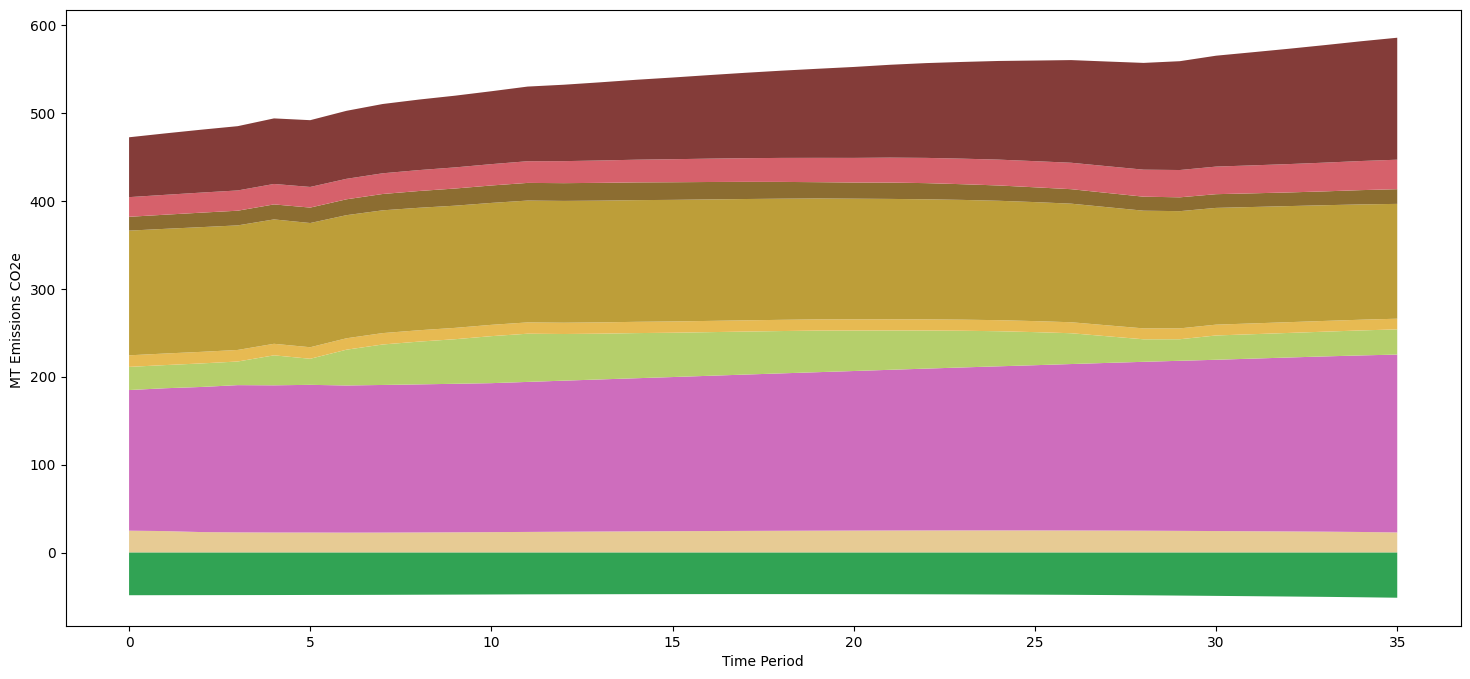

In [55]:

fig, ax = plt.subplots(figsize = (18, 8))
ax.set_xlabel("Time Period")
ax.set_ylabel("MT Emissions CO2e ")

df_plot = df_out[
    df_out[ssp.key_primary].isin([71071])
]


fields = matt.get_all_subsector_emission_total_fields()#[x for x in df_out.columns if (x.startswith("emission_co2e_subsector_total"))]
dict_format = dict(
    (k, {"color": v}) for (k, v) in
    matt.get_subsector_color_map().items()
)

fig, ax = spu.plot_stack(
    df_plot,
    fields,
    dict_formatting = dict_format,
    field_x = "time_period",
    figtuple = (fig, ax),
)


# Export Wide File (Last Mandatory Step)

In [56]:
df_out = ssp.read_output(None)
df_in = ssp.read_input(None)


all_primaries = sorted(list(df_out[ssp.key_primary].unique()))

# build if unable to simply read the data frame
if df_in is None:
    df_in = []
     
    for region in ssp.regions:
        for primary in all_primaries: 
            df_in_filt = ssp.generate_scenario_database_from_primary_key(primary)
            df_in.append(df_in_filt.get(region))
    
    df_in = pd.concat(df_in, axis = 0).reset_index(drop = True)




df_export = pd.merge(
    df_out,
    df_in,
    how = "left",
)



# check output directory 
dir_pkg = os.path.join(
    ssp.file_struct.dir_out, 
    f"sisepuede_summary_results_run_{ssp.id_fs_safe}"
)
os.makedirs(dir_pkg) if not os.path.exists(dir_pkg) else None


for tab in ["ATTRIBUTE_STRATEGY"]:
    table_df = ssp.database.db.read_table(tab)
    if table_df is not None:
        table_df.to_csv(
            os.path.join(dir_pkg, f"{tab}.csv"),
            index=None,
            encoding="UTF-8"
        )
    else:
        print(f"Warning: Table {tab} returned None.")


df_primary = (
    ssp
    .odpt_primary
    .get_indexing_dataframe(
        sorted(list(df_out[ssp.key_primary].unique()))
    )
)
    
df_primary.to_csv(
    os.path.join(dir_pkg, f"ATTRIBUTE_PRIMARY.csv"),
    index = None,
    encoding = "UTF-8"
)

df_export.to_csv(
    os.path.join(dir_pkg, f"sisepuede_results_{ssp.id_fs_safe}_WIDE_INPUTS_OUTPUTS.csv"),
    index = None,
    encoding = "UTF-8"
)

In [57]:
# Getting the directory where the outputs are stored
ssp.file_struct.dir_out

'/home/tony-ubuntu/anaconda3/envs/mexico_env/lib/python3.11/site-packages/sisepuede/out'

## Some Optional Plotting

In [58]:
# primary_id = 0

# df_prim = df_out[
#     df_out[
#         ssp.key_primary
#     ]
#     .isin([primary_id])
# ]

# df_in_cur = df_in[
#     df_in[
#         ssp.key_primary
#     ]
#     .isin([primary_id])
# ]


# fields_plot = [
#     x for x in df_prim.columns
#     if "investment" in x
#     and df_prim[x].max() > 0
# ]
# (
#     df_prim[fields_plot]
#     .plot(
#         legend = True,
#     )
# )




In [59]:


# fig, ax = plt.subplots(figsize = (15, 10))
# df_resid = matt.extract_model_variable(
#     df_in_cur,
#     "NemoMod ResidualCapacity"
# )
# (
#     df_resid
#     .plot
#     .area(
#         ax = ax
#     )
# )

In [60]:
# df_resid

In [61]:
# [x for x in df_out.columns if "capacity" in x]

In [62]:
# ssp.model_attributes.configuration.dict_config


In [63]:
# modvar = matt.get_variable("NemoMod Generation Capacity")
# modvar.get_from_dataframe(df_prim).head()

In [64]:
# #[x for x in matt.all_variables if "Consumption" in x]
# [x for x in matt.all_variables if "Production" in x]
# modvar = matt.get_variable("NemoMod Production by Technology")


# unit = matt.get_unit("energy")
# (modvar.get_from_dataframe(df_prim).iloc[7].sum()*unit.convert("PJ", "mwh")/1000)/367669

In [65]:
# df_inputs

In [66]:
# modvar = matt.get_variable("Total Energy Consumption from Industrial Energy")#Industrial Energy")
# matt.extract_model_variable(
#     df_prim,
#     modvar
# )